### Angle encoding
In this example, a randomly generated vector is encoded using the angle encoding method.

The results of the encoding are examined and compared to the expected results.

Finally, the performance of the encoding algorithm is also showcased on a real quantum computer.

---

Firstly, the `qsp` package that contains the encoding algorithms is imported (it is essential to preserve the same file structure as in the published repository; otherwise, the import may not work):

In [1]:
import os

# Get the directory of this Notebook file:
current_notebook_directory = get_ipython().run_line_magic("pwd", "").strip()

# Change the current working directory to this Notebook's directory:
os.chdir(current_notebook_directory)

# Move up two directories (to the root of the repository):
os.chdir("./../../")

# Import the quantum state preparation package:
import qsp

# Change the current working directory to this Notebook's directory:
os.chdir('./notebooks/encoding_demonstration')

This example demonstrates the angle encoding method by encoding a random input vector containing real numbers. Thus, the first step is to generate a random vector. The vector is sampled uniformly at random from the `Haar measure`. The `Haar measure` is used to ensure that the resulting qubit states (obtained by encoding the vector elements) are random. If the uniform distribution were to be used, the sine function used during the encoding would result in the states not being uniformly distributed on the Bloch sphere. The `length` of the vector can be specified:

In [2]:
# The length of the vector to be generated and encoded:
length = 3

In [3]:
# To reduce the length of this Notebook and to avoid duplicate
# code in multiple Notebooks, the code that is not important for this
# encoding method demonstration is located in the "helpers.py" file:
import helpers

# Generate a normalized vector sampled
# uniformly at random from the Haar measure:
input_vector = helpers.generate_haar_random_vector(length)

print("The generated normalized input vector:", input_vector)

The generated normalized input vector: [0.74651424 0.43896263 0.5000283 ]


In the angle encoding method, if a square of the normalized input vector is taken, each squared vector element equals the desired probability of the corresponding qubit collapsing to the state $\ket{1}$ when measured (assuming the standard basis is used). The squared input vector is stored in the `expected_probabilities` list:

In [4]:
import numpy as np

# Calculate the expected probabilities of qubits
# collapsing to the state |1> by squaring the input vector:
expected_probabilities = np.power(input_vector, 2)

print("The expected probabilities:", expected_probabilities)

The expected probabilities: [0.55728351 0.19268819 0.2500283 ]


The implementation of the angle encoding technique from the `qsp` package embeds each element of the generated input vector into a unique qubit using a `ry` gate. This method ensures that the probability of measuring each qubit in the state $\ket{1}$ is equal to the desired probability stored in the `expected_probabilities` list. The amount of qubits used in the resulting quantum circuit is the same as the length of the input vector.

The generated input vector is encoded by creating a `qsp.AngleEncoding` instance and passing the input vector as an argument:

In [5]:
# Encode the input vector using the angle encoding method:
encoding = qsp.AngleEncoding(input_vector)

Now that the input vector is encoded, the created quantum circuit that encodes the input vector is shown:

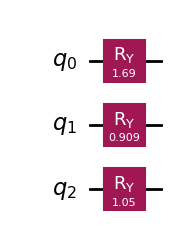

In [6]:
# Show the quantum circuit:
encoding.quantum_circuit.draw("mpl")

Next, a basic simulation is performed where all qubits are measured using the default `Aer.AerSimulator()` and the results of the simulation are plotted. The number of times the simulation is performed can be specified using the `shots` variable:

In [7]:
# How many times the simulation should be performed.
# This value is also used later in this Notebook.
shots = 10000

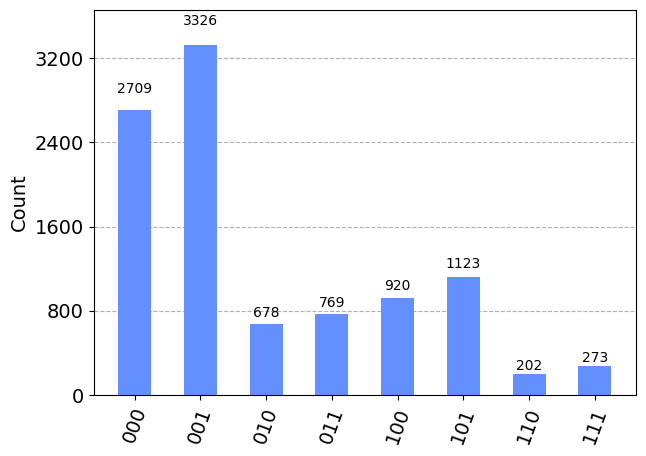

In [8]:
# Run the basic aer simulation, show a plot with the results,
# and save the counts dictionary of the simulation for later use:
counts = encoding.run_aer_simulator(shots).get_counts()

If some states are missing from the simulation results, they are added to the `counts` dictionary (with the count being zero). This step is necessary to ensure the subsequent functions work correctly.

In [9]:
# Add all possible states to the counts dictionary if they are not present:
helpers.add_states_if_missing(counts)

Now, the simulation results are used to create a list containing the number of times each qubit has collapsed to the state $\ket{1}$:

In [10]:
# Get the number of collapses to the state |1> for each qubit:
qubit_results = helpers.results_for_qubits(counts)

The numbers indicating how many times each qubit has collapsed to the state $\ket{1}$ are shown in the table below, along with the expected numbers. The `expected_probabilities` vector directly contains the desired probabilities of measuring each qubit in the state $\ket{1}$. These expected probabilities are multiplied by the number of `shots` of the simulation to obtain the expected number of collapses to the state $\ket{1}$ for each qubit:

In [11]:
# Display a table containing the expected and actual
# number of the collapses to the state |1> for each qubit:
helpers.show_qubit_results_table(shots, expected_probabilities, qubit_results)

,Qubit,Expected count for |1>,Actual count for |1>
0,0,5573,5491
1,1,1927,1922
2,2,2500,2518


In the angle encoding method, one qubit per element of the generated input vector is used to encode the input vector. So, the length of the `expected_probabilities` vector is the same as the number of qubits in the previously constructed quantum circuit. That means each element of the `expected_probabilities` vector equals the probability of measuring the respective qubit in the state $\ket{1}$.

To obtain the probability of measuring each possible state of the whole quantum system (not just the individual qubits), the `expected_probabilities` vector can be used. The probability of measuring a given composite state can be calculated by multiplying probabilities of individual qubits collapsing to their respective states. Next, these probabilities are stored in the `state_probabilities_expected` list. This list is used in charts later in this Notebook. The length of this list is equal to $2^n$, where $n$ is the length of the input vector. The list is sorted such that its i-th element represents the probability of measuring the quantum state in the state described by the i-th binary string, where binary strings of length $n$ are ordered by their least significant bit:

In [12]:
# Get the probabilities of measuring the
# quantum system in each possible state:
state_probabilities_expected = helpers.calculate_state_probabilities(
    expected_probabilities
)

Simulation results do not guarantee that an encoding algorithm works correctly. The more accurate way to determine whether an encoding method produced the desired results for a given input vector is to get a statevector of the quantum system after all the required gates are added to the quantum circuit. Then, after squaring such statevector, the elements of that squared statevector correspond to the probabilities of measuring each possible composite state (this approach is suitable for the angle encoding method but may not be suitable for some different encoding techniques).

In [13]:
# Get the statevector of the quantum state after applying all the gates:
statevector = encoding.get_statevector().data

# Calculate the probabilities of measuring each possible
# state (use absolute values to discard the complex parts;
# each complex part equals zero in this case anyway):
state_probabilities_actual = np.abs(statevector) ** 2

The `state_probabilities_actual` list now contains the actual probabilities of measuring each possible state. The length of this list is equal to $2^n$, where $n$ is the length of the input vector. The list is sorted such that its i-th element represents the probability of measuring the quantum state in the state described by the i-th binary string, where binary strings of length $n$ are ordered by their least significant bit.

These obtained probabilities can be compared to the expected probabilities given by the input vector to see whether the encoding works correctly for this specific generated input vector. If the encoding works as intended, both `state_probabilities_expected` and `state_probabilities_actual` lists should be identical:

In [14]:
# Compare the expected probabilities of the generated
# vector with the actual probabilities of the quantum
# system after applying all the gates and display the result:
helpers.compare_probabilities_expected_actual(
    state_probabilities_expected, state_probabilities_actual
)

The expected probabilities are the same as the actual probabilities.


To see all the previously discussed data at a glance, a bar plot is shown containing the simulation counts, along with the expected and the actual probabilities of measuring each possible state of the quantum system:

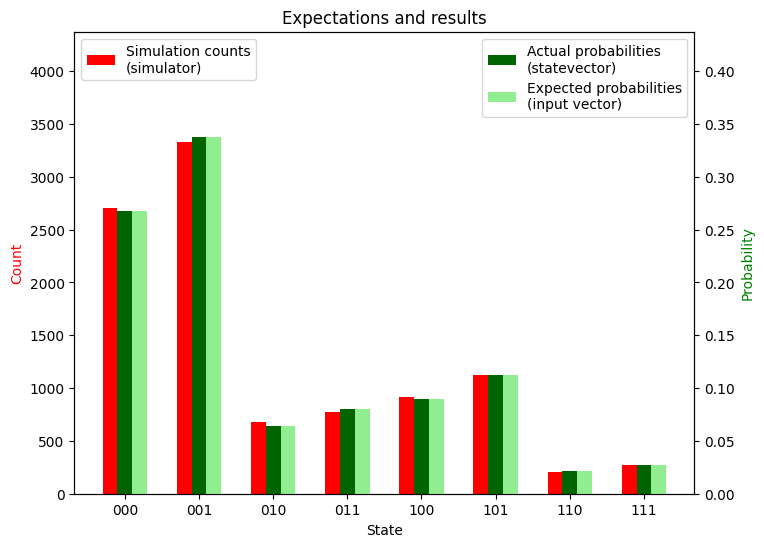

In [15]:
# Show the simulation counts, expected probabilities,
# and actual probabilities in a single bar plot:
helpers.compare_results_simulation_plot(
    shots, counts, state_probabilities_expected, state_probabilities_actual
)

In the following section of this Notebook, measurements are performed on a real quantum computer to see the performance of this encoding method on one of the `IBM Quantum` computers.

The least busy backend instance is chosen to run the previously constructed quantum circuit on, even though it may have far more qubits than required by the circuit:

In [16]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Create a QiskitRuntimeService instance with 'ibm_quantum'
# chosen as the channel (the other possibility is 'ibm_cloud',
# but in this repository, IBM Quantum is used):

# Save your IBM Quantum API token first using the
# QiskitRuntimeService.save_account() method or
# specify your token directly in the QiskitRuntimeService()
# constructor by passing your token in the "token" parameter.
service = QiskitRuntimeService(
    channel="ibm_quantum",
    # Use the instance "ibm-q/open/main" available to
    # all if you do not have access to a custom instance:
    instance="cvut/general/d-c-state-prep",
)

# Fetch the least busy quantum computer (one that has the fewest jobs queued):
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=length)

Show some basic information about the chosen quantum computer:

In [17]:
from datetime import datetime

# Get the current date and save it in a readable format:
current_date = datetime.now().strftime("%B %d, %Y")

# Show some basic information about the chosen quantum
# computer (also print the current date, because the
# retrieved information may become outdated over time,
# or the computer itself may become deprecated):
print(
    f"The chosen backend information (this information was retrieved on {current_date}):\n"
    f"Backend name: {backend.name}\n"
    f"Number of qubits: {backend.num_qubits}\n"
    f"Version of Backend class: {backend.version}\n"
    f"The date that the device went online: {backend.online_date}\n"
    f"The number of pending jobs currently on the backend: {backend.status().pending_jobs}\n"
    f"Instructions supported by the backend: {backend.supported_instructions}"
)

The chosen backend information (this information was retrieved on May 10, 2024):
Backend name: ibm_osaka
Number of qubits: 127
Version of Backend class: 2
The date that the device went online: 2023-10-09 04:00:00+00:00
The number of pending jobs currently on the backend: 13
Instructions supported by the backend: ['ecr', 'id', 'delay', 'measure', 'reset', 'rz', 'sx', 'x', 'if_else', 'for_loop', 'switch_case']


To get measurement results by running a circuit on a backend, the `Sampler` primitive is used. The `Sampler` primitive is initialized with the chosen backend:

In [18]:
from qiskit_ibm_runtime import SamplerV2

# Initialize the Sampler primitive with the chosen backend:
sampler = SamplerV2(backend=backend)

It is essential to add measurements to a quantum circuit before running it on a quantum computer using the `Sampler` primitive. When using the angle encoding method, all qubits need to be measured to obtain the proper encoding results:

In [19]:
# Add measurements to the circuit:
encoding.quantum_circuit.measure_all()

The circuit contains `ry` gates, but these gates are not supported by `IBM Quantum` backends. Before running a job on a backend, the circuit needs to be transpiled so that it only contains gates that are supported (each backend may support a different set of operations):

In [20]:
import qiskit

# Transpile the circuit so that it only contains gates that are
# supported by the backend. Keep the optimization level set to 0 to
# test the worst-case scenario when the encoding is not optimized:
transpiled_circuit = qiskit.transpile(
    encoding.quantum_circuit, backend, optimization_level=0
)

The transpiled circuit may differ from the original circuit if the gates that are not supported are replaced. Both original and transpiled circuits are visualized below to outline all the differences between them:

The original circuit:


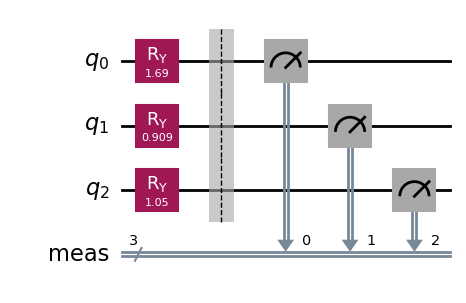

The transpiled circuit:


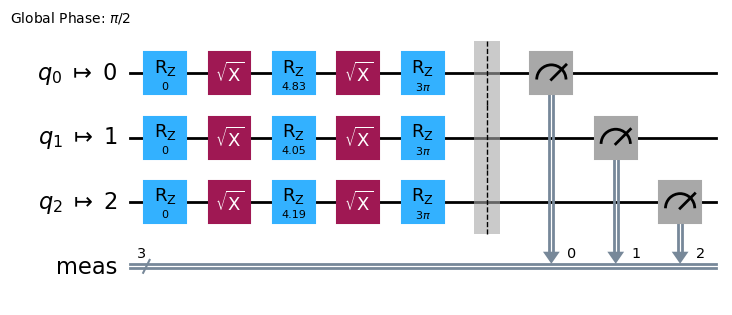

In [21]:
print("The original circuit:")

# Show the quantum circuit:
display(encoding.quantum_circuit.draw("mpl"))

print("The transpiled circuit:")

# The transpiled circuit contains at least 127 qubits (the least qubits
# available on any IBM Quantum computer as of May 2024), which makes it
# difficult to be drawn. To draw it, empty qubits need to be deleted
# first. First, a copy of the transpiled circuit is created:
transpiled_circuit_draw = transpiled_circuit.copy()

# The qubits from the circuit are stored in a variable for convenience:
qubits = transpiled_circuit_draw.qubits

# Remove the empty qubits from the copy of the transpiled circuit:
for _ in range(length, len(qubits)):
    transpiled_circuit_draw.qubits.pop()

# Show the copy of the transpiled circuit:
display(transpiled_circuit_draw.draw("mpl"))

Now, the circuit is ready to be run on the backend. A job is created and added to the backend queue by running the circuit through the `Sampler`:

In [22]:
# Create a job and run it on the chosen quantum computer through
# the `Sampler` primitive (the circuit must be passed in a list):
job = sampler.run([transpiled_circuit], shots=shots)

After waiting for the job to complete, the job result is displayed:

In [23]:
# Wait for the job to complete and get the results:
result_real_backend = job.result()

# Print the result of the completed job:
print(result_real_backend)

PrimitiveResult([PubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=10000, num_bits=3>)), metadata={'circuit_metadata': {}})], metadata={'version': 2})


The measurement results are extracted from the job result and displayed:

In [24]:
# Get the first (and only) PubResult:
pub_result = result_real_backend[0]

# Get the measurement results from the classical
# register 'meas' of the PubResult and print them:
counts_real_backend = pub_result.data.meas.get_counts()
print("\nThe measurement results:\n", counts_real_backend)


The measurement results:
 {'000': 3081, '001': 2968, '101': 1018, '011': 656, '100': 1116, '010': 673, '111': 246, '110': 242}


If some states are missing from the obtained measurement results stored in the `counts_real_backend` dictionary, they are added, with the count being zero (this step is necessary to ensure the following plotting function works correctly):

In [25]:
# Add all possible states to the
# "counts_real_backend" dictionary if they are absent:
helpers.add_states_if_missing(counts_real_backend)

A bar plot is shown to visualize how these results compare to the simulation results and the expected results calculated earlier:

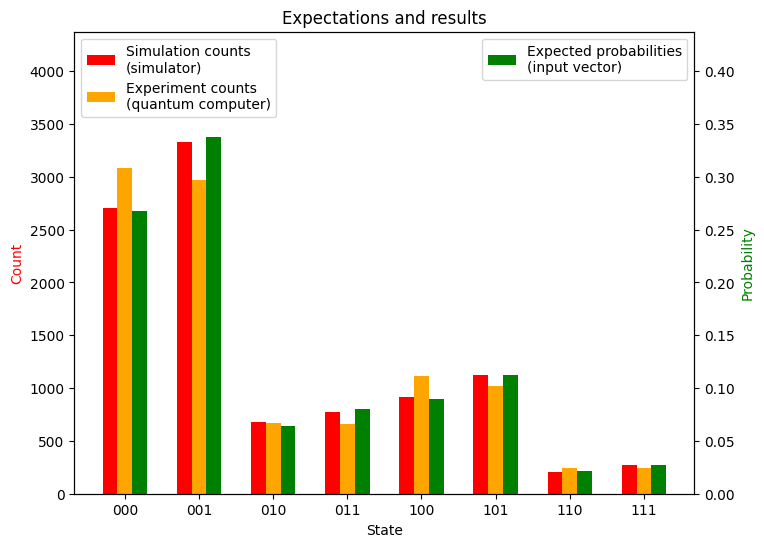

In [26]:
# Show the experiment counts, simulation counts
# and expected probabilities in a single bar plot:
helpers.compare_results_experiment_plot(
    shots, counts, counts_real_backend, state_probabilities_actual
)

One of the ways to quantify the extent to which the results of the measurements on the quantum computer correspond to the expected results defined by the input vector is to use a measure called `fidelity`. In simple terms, the `fidelity` between two quantum states quantifies how similar or different these states are. It ranges from 0 to 1, where 1 indicates that the states are identical, and 0 indicates that they are completely orthogonal. Given two pure quantum states, the `fidelity` between them is defined as the absolute square of their inner product. The closer the `fidelity` is to 1, the better an encoding method performs on quantum computers. The more errors happen during a computation on a quantum computer, the lower the `fidelity` may be.

Next, the fidelity between two pure quantum states is calculated. One of these pure states is derived from the generated input vector, it is stored in the `statevector` variable. The other pure state is obtained by approximation, where the probability distribution of quantum states is inferred from the measurement results by normalizing the measurement outcomes from the `counts_real_backend` variable:

In [27]:
# Calculate the fidelity between the "statevector" state and
# the state obtained from the "counts_real_backend" dictionary:
fidelity = helpers.calculate_fidelity(shots, statevector, counts_real_backend)

print("The fidelity between the states is:", fidelity)

The fidelity between the states is: 0.994863340901345


Another measure of the distinguishability between two quantum states is the `trace distance`. The `trace distance` for pure states directly relates to the `fidelity`. For two pure quantum states, the `trace distance` is defined as the square root of one minus the `fidelity` between them. So, the closer the `trace distance` is to 0, the "closer" the states are to each other.

In the final section of this Notebook, the `trace distance` is calculated between the state defined by the `statevector` variable and the state obtained by approximation from the `counts_real_backend` variable:

In [28]:
# Calculate the trace distance between the "statevector" state and
# the state obtained from the "counts_real_backend" dictionary:
trace_distance = helpers.calculate_trace_distance(shots, statevector, counts_real_backend)

print("The trace_distance between the states is:", trace_distance)

The trace_distance between the states is: 0.07167048973360665
